In [6]:
import tensorflow as tf
from keras.layers import Input, Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D, concatenate, Activation
from keras.applications.mobilenet import MobileNet as Net

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.layers import Input, merge
from keras.optimizers import Adam
import cv2
import numpy as np
import os
from tqdm import tqdm
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

ALPHA = 0.3  # Triplet Loss Parameter

from keras.layers import Input,Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D,concatenate,Activation
from keras.applications.xception import Xception as Net
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import Model

import pydot
import graphviz
import time
import glob


import matplotlib.pyplot as plt

In [7]:
def triplet_loss(x):
    anchor, positive, negative = x
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]]) ------ tf.reduce_sum(x, 1)  # [3, 3]
    #It is trained in batches so, the tensor will be of the above shape for each triplet
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    
    #x = tf.constant([[1, 1, 1], [1, 1, 1]])--------->tf.reduce_sum(x, 0)  # [2, 2, 2]

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss

In [8]:
def make_model(input_shape):
    
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    
    return cnn_model

In [9]:
def create_model(d1, d2, c):
    
    # The triplet network takes 3 input images: 2 of the same class and 1 out-of-class sample
    #shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) 
    #indicates that the expected input will be batches of 32-dimensional vectors.
    
    anchor_example =   Input(shape=(d1, d2, c), name = 'anchor')
    positive_example = Input(shape=(d1, d2, c), name = 'positive')
    negative_example = Input(shape=(d1, d2, c), name = 'negative')
        
    #base_model = Net(input_shape=(d1,d2,3),weights='imagenet',include_top=False)
    base_model = make_model(input_shape=(d1, d2, c))
    # the weights of this layer will be set to ones and fixed  (since they
    # are shared we could also leave them trainable to get a weighted sum)
    
    # feed all 3 inputs into the pretrained keras model
    x1 = base_model(anchor_example)
    x2 = base_model(positive_example)
    x3 = base_model(negative_example)
    
    # flatten/summarize the models output:
    # (here we could also use GlobalAveragePooling or simply Flatten everything)
    #Takes the max value for each of the filter
    anchor =   GlobalMaxPooling2D()(x1)
    positive = GlobalMaxPooling2D()(x2)
    negative = GlobalMaxPooling2D()(x3)
    
    
    #Loss gives the final loss value between a,p and n.
    loss = merge([anchor, positive, negative], mode=triplet_loss, output_shape=(1,))

    
    triplet_model = Model(inputs=[anchor_example, positive_example, negative_example],
                  outputs=loss)
    
    triplet_model.compile(loss='mean_absolute_error', optimizer=Adam())
    print(triplet_model.summary())
    
    return triplet_model


In [10]:
triplet_model=create_model(128, 128, 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 62, 62, 64)   19392       anchor[0][0]                     
                                                                 positive[0][0]                   
          

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Applications/anaconda/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [15]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(triplet_model).create(prog='dot', format='svg'))

In [11]:
triplet_str=[]

t1= time.time()
for i in range(1,13):
    for ja in range(1,6):
        for k in range(23,52):
             for jn in range(1,6):
                    for jp in range(1,6):
                        #print (i,ja,k,jn,jp)
                        if (jp!=ja):
                            
                            if(i<10):
                                a='00'+ str(i)+'_00'+str(i)+'_00'+str(ja)
                                b='00'+ str(i) +'_00'+str(i)+'_00'+str(jp)
                                c='0'+str(k)+'_00'+str(i)+'_00'+str(jn)
                            else:
                                a='0'+str(i)+'_0'+str(i)+'_00'+str(ja)
                                b='0'+str(i)+'_0'+str(i)+'_00'+str(jp)
                                c='0'+str(k)+'_0'+str(i)+'_00'+str(jn)
                            
                            x= (a,b,c)
                            triplet_str.append(x)
                        
                    
t2=time.time()

print (t2-t1)

0.15180182456970215


In [12]:
def img_to_array(image):
    img = cv2.resize(image, (128, 128)) 
    x_train = np.array([img])
    return x_train

In [13]:
def img_path_to_array(image_path):
    img1 = cv2.imread(image_path, 1)
    return img_to_array(img1)

In [14]:
def prepare_database():
    database = {}

    # load all the images of individuals to recognize into the database
    for file in glob.glob("images/*"):
        identity = os.path.splitext(os.path.basename(file))[0].strip('NISDCC-_6g')
        #print (identity)
        database[identity] = img_path_to_array(file)

    return database

In [15]:
train_image_arrays = prepare_database()

In [16]:
anchor=[]
positive=[]
negative=[]

for img_name in triplet_str:
    anchor.append(train_image_arrays[img_name[0]])
    positive.append(train_image_arrays[img_name[1]])
    negative.append(train_image_arrays[img_name[2]])

In [105]:
#np.reshape(anchor,(len(anchor),128,128,3

In [17]:
x_a=np.array(anchor).reshape((len(anchor), 128,128,3))
x_p=np.array(positive).reshape((len(positive), 128,128,3))
x_n=np.array(negative).reshape((len(negative), 128,128,3))

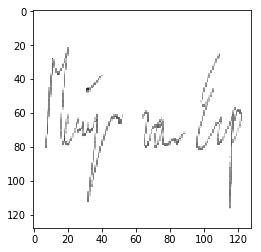

(128, 128, 3)

In [18]:
plt.imshow(x_a[100])
plt.show()
x_a[1].shape

In [ ]:
'''def generator():
    dataset=load_images("images/*")

    anchor=[]
    p_img=[]
    n_img=[]
    
    for i,j,k in dataset:
        anchor.append(i)
        p_img.append(j)
        n_img.append(k)
    
    anchor=np.array(anchor)
    p_img=np.array(p_img)
    n_img=np.array(n_img)
    
    return anchor, p_img, n_img
'''

In [19]:
triplet_model.fit(x=[x_a, x_p, x_n], y=np.zeros(x_a.shape[0]), verbose=1, batch_size=1024, epochs=1) 

Epoch 1/1
34800/34800 [==============================] - 23283s 669ms/step - loss: 3.1624
